# Projekt 2 - klasteryzacja
## Temat 3 - Text classification Documentation

### Plan projektu

1. Wstęp
2. Wczytanie danych i wstępne informacje

    2.1. Cel biznesowy
    
3. Czyszczenie danych

    3.1. Duplikaty i brakujące wartości
    
    3.2. Stopwords i inne fragmenty nieistotne semantycznie

4. Wizualizacja danych

    4.1. wordcloud

    4.2. plotly

    4.3. scattertext

5. Wnioski

Komentarze od zespołu walidacyjnego zostały dodane kolorem <font color="red">czerwonym</font>


### 1. Wstęp

Celem niniejszego projektu jest przeprowadzenie analizy zawartości dokumentów, ze szczególnym uwzględnieniem rozkładu słów i tematów. Zacznijmy od wczytania potrzebnych pakietów i bibliotek:

In [36]:
# pip install pillow
# nltk.download('stopwords')
# nltk.download('punkt')
# pip install wordcloud
# pip install scattertext

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.colors as mcolors
from wordcloud import WordCloud
from collections import Counter
import re
import plotly.express as px
import scattertext as st
import spacy
spacy.load('en_core_web_sm')

### 2. Wczytanie danych i wstępne informacje

Zacznijmy od wczytania danych pobranych ze strony kaggle.com.

Są to fragmenty wiadomości z portalu BBC, pochodzące z lat 2004-2005.

#### 2.1. Cel biznesowy

Celem biznesowym naszego projektu jest stworzenie produktu, który z łatwością będzie klasyfikował teksty do jednej z pięciu możliwych kategorii: Politics, Technology, Sport, Business oraz Entertainment. Skierowany będzie do redakcji czasopism - dzięki takiemu produktowi redaktorzy nie będą musieli samodzielnie klasyfikować nadesłanych przez poszczególnych dziennikarzy artykułów - system będzie robił to automatycznie.



<font color="red"> Jasno postawiony, klarowny cel biznesowy. </font>

In [2]:
X_train = pd.read_csv('data\\X_train.csv')
y_train = pd.read_csv('data\\y_train.csv')

df = X_train
df['Label'] = y_train

<font color="red">Brak informacji o tym, w jaki sposób następował podział danych na zbiór treningowy, testowy i walidacyjny. Czy był to wybór losowy? </font>

Podejrzyjmy, jak wyglądają dane:

In [3]:
df.head()

,Text,Label
0,Double eviction from Big Brother\n \n Model Ca...,3
1,Ailing EuroDisney vows turnaround\n \n EuroDis...,4
2,Japanese growth grinds to a halt\n \n Growth i...,4
3,Small firms 'hit by rising costs'\n \n Rising ...,4
4,Mexicans tracking unhappy Juninho\n \n Mexican...,1


### 3. Czyszczenie danych

#### 3.1 Duplikaty i brakujące wartości

Zajmiemy się teraz sprawdzeniem, czy w danych występują duplikaty lub brakujące wartości, a następnie je wyczyścimy.

Sprawdźmy, czy w danych mamy jakieś duplikaty:

In [4]:
duplicates = X_train[X_train.duplicated(subset='Text', keep='first')]
len(duplicates)

20

Jak widać duplikaty występują. Usuńmy je:

In [5]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)

In [6]:
duplicates = df[df.duplicated(subset='Text', keep='first')]
len(duplicates)

0

Duplikaty zostały usunięte poprawnie.

<font color="red">Trafne podejście z usuwaniem duplikatów.</font> 

In [7]:
X_train = pd.DataFrame(df['Text'])
y_train = pd.DataFrame(df['Label'])
X_train.columns = ['Text']
y_train.columns = ['Label']

<font color="red">Zastanawiamy się, czy w ramach klasteryzacji można w ogóle korzystać z kolumny ‘label’. Naszym zdaniem nie. W końcu jest to uczenie nienadzorowane i formalnie nie powinno korzystać się z etykiet. Podobnie jest z wykresami tworzonymi z podziałem na różne tematy. Rzeczywiście to pozwala lepiej poznać strukturę zbioru danych, jednak w klasteryzacji klastry powinny być raczej wyodrębnione na podstawie zróżnicowania danych (za pomocą jakiegoś modelu), a nie znane już na samym początku. </font>

Zobaczmy, czy w danych występują brakujące wartości:

In [1]:
X_train['Text'].isnull().any()


KeyboardInterrupt



Jak widać nie ma brakujących wartości. Sprawdźmy też, czy fragmenty tekstów, które analizujemy, mają sensowne długości. Jeśli otrzymalibyśmy rekordy zawierające zaledwie kilka znaków, można by wywnioskować, że takie dane są niepoprawne - musielibyśmy przyjrzeć się temu bliżej:

In [9]:
min_length = X_train['Text'].apply(lambda x: len(str(x))).min()
min_length

725

In [10]:
max_length = X_train['Text'].apply(lambda x: len(str(x))).max()
max_length

16249

Jak widać długości tekstów wydają się poprawne jak na artykuły z wiadomości. Nie musimy przeprowadzać dalszej analizy pod tym kątem.

#### 3.2. Stopwords i inne fragmenty nieistotne semantycznie

Przeprowadzimy teraz analizę pod kątem rozkładu słów i innych fragmentów tekstu występujących w danych.

In [11]:
y_train['Label'].nunique()

5

Widzimy, że kolumna Label przechowuje 5 różnych wartości. Mamy zatem 5 kategorii, do których należą badane przez nas fragmenty tekstów.

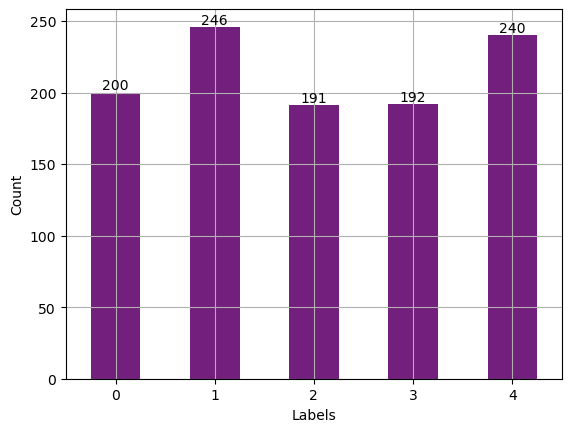

In [12]:
value_counts = y_train['Label'].value_counts().sort_index()
value_counts.plot(kind='bar', color='#731F7D')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=0)
for index, value in enumerate(value_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.grid(None)
plt.show()

Dane są w miarę równomiernie rozłożone, mamy porównywalne ilości rekordów z każdej kategorii.

Sprawdźmy teraz, jakie są najczęściej występujące w naszych danych słowa:

In [13]:
words = df['Text'].apply(word_tokenize).sum()
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)

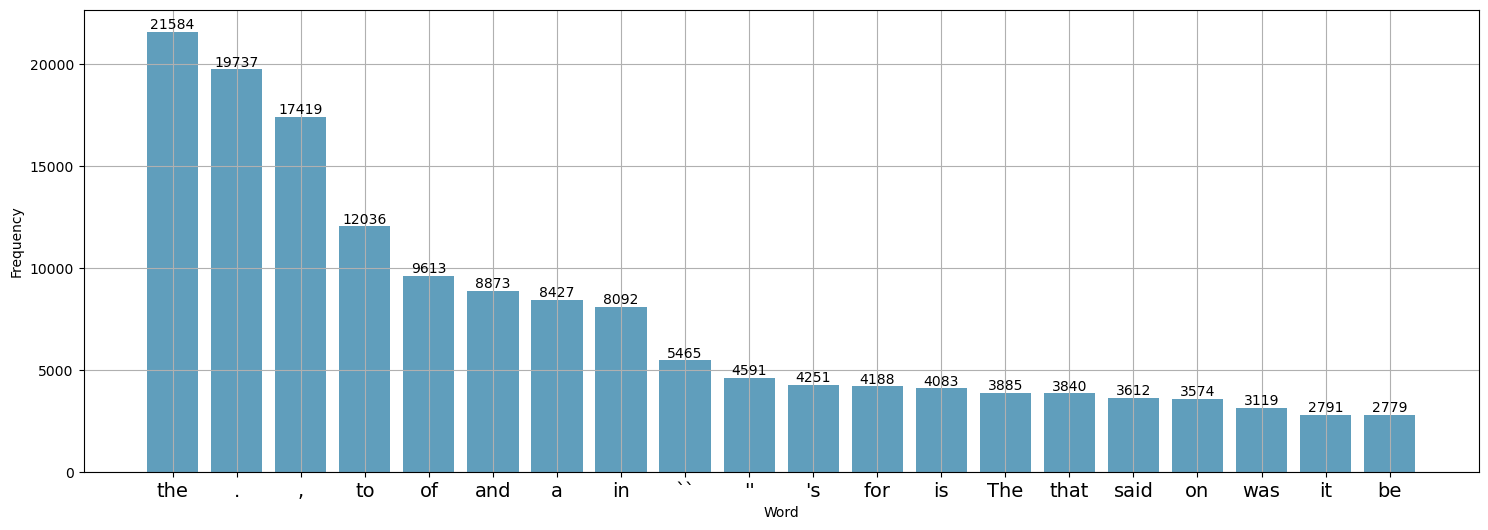

In [14]:
words, counts = zip(*most_common_words)
plt.figure(figsize=(18, 6))
plt.bar(words, counts, color='#609ebc')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=0, fontsize=14)

for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom', fontsize=10)
plt.grid(None)
plt.show()

Jak widać, najczęściej występujące słowa to tzw. stopwords - to słowa, które często występują w języku (w naszym przypadku angielskim), ale nie niosą za sobą znaczenia (przykłady poniżej). Docelowo będziemy chciały usunąć te słowa z naszych danych, aby skupić się na tych, które mają większą wartość semantyczną i pozwolą nam na późniejszą klasyfikację tekstów do odpowiednich kategorii.

In [15]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Zdefiniujmy funkcję, która wyczyści tekst ze stopwordsów oraz znaków numerycznych - otrzymamy tylko istotne semantycznie słowa. Ponadto zastąpi wszystkie wielkie litery małymi:

In [16]:
def clean_text(text):
    stopwords_set = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    words = [word for word in tokens if word.isalpha() and word not in stopwords_set]
    return words

Zobaczymy teraz na wykresie, jakie są najczęściej występujące słowa w całym zbiorze danych:

In [17]:
words = X_train['Text'].apply(clean_text).sum()
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)

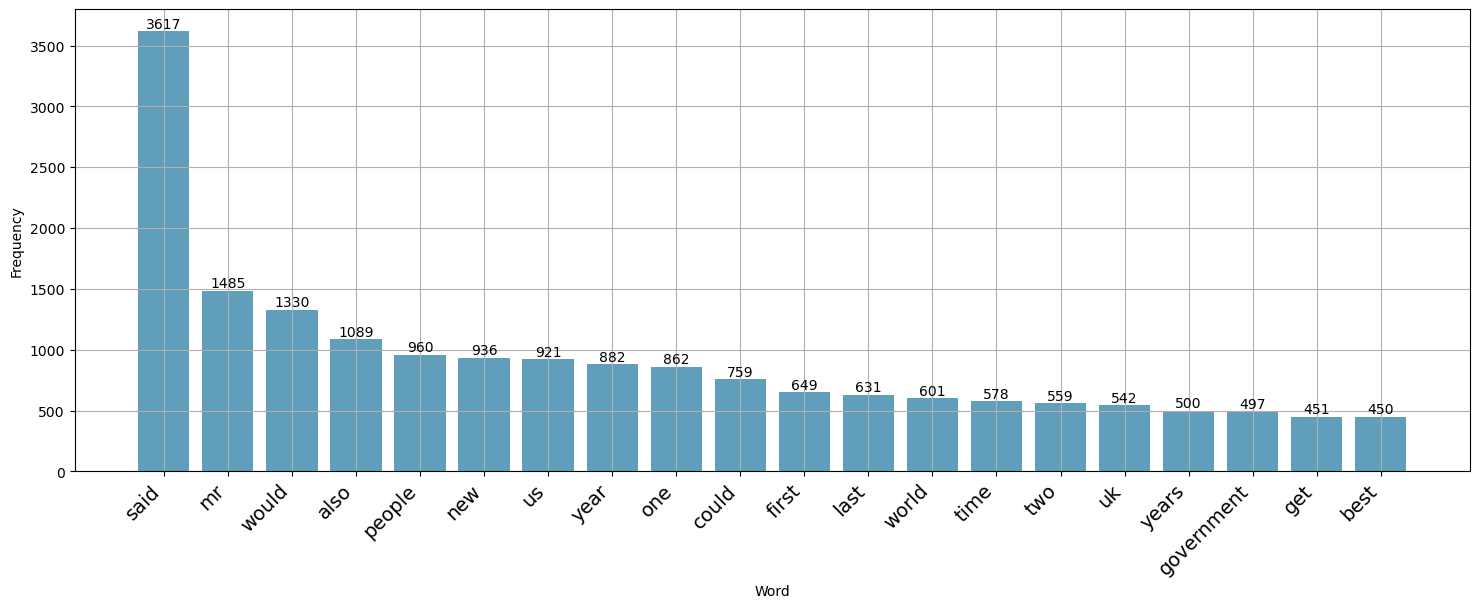

In [18]:
words, counts = zip(*most_common_words)
plt.figure(figsize=(18, 6))
plt.bar(words, counts, color='#609ebc')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, fontsize=14, ha='right')

for i in range(len(counts)):
    plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom', fontsize=10)
plt.grid(None)
plt.show()

Dodajmy do naszej ramki danych kolumnę z wyczyszczonymi tekstami jako jeden string.

In [19]:
df['Cleaned_text'] = df['Text'].apply(lambda x: ' '.join(clean_text(x)))

In [20]:
df.head()

,Text,Label,Cleaned_text
0,Double eviction from Big Brother\n \n Model Ca...,3,double eviction big brother model caprice holb...
1,Ailing EuroDisney vows turnaround\n \n EuroDis...,4,ailing eurodisney vows turnaround eurodisney e...
2,Japanese growth grinds to a halt\n \n Growth i...,4,japanese growth grinds halt growth japan evapo...
3,Small firms 'hit by rising costs'\n \n Rising ...,4,small firms rising rising fuel materials costs...
4,Mexicans tracking unhappy Juninho\n \n Mexican...,1,mexicans tracking unhappy juninho mexican outf...


Wyczyścimy teraz dane z poszczególnych kategorii i sprawdzimy na wykresie, jak rozkładają się najczęściej występujące słowa:

In [21]:
for i in range(5):
    temp = df.loc[df['Label'] == i]
    words = temp['Text'].apply(clean_text).sum()
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(10)
    print('label:', i, 'words:', [most_common_words[j][0] for j in range(len(most_common_words))])

label: 0 words: ['said', 'mr', 'would', 'labour', 'government', 'people', 'election', 'blair', 'party', 'also']
label: 1 words: ['said', 'england', 'game', 'would', 'first', 'win', 'world', 'last', 'one', 'time']
label: 2 words: ['said', 'people', 'mr', 'also', 'would', 'could', 'one', 'new', 'technology', 'music']
label: 3 words: ['said', 'film', 'best', 'also', 'one', 'year', 'new', 'us', 'music', 'awards']
label: 4 words: ['said', 'us', 'mr', 'year', 'would', 'new', 'company', 'also', 'growth', 'economy']


Zobaczmy, jak to wygląda na wykresach:

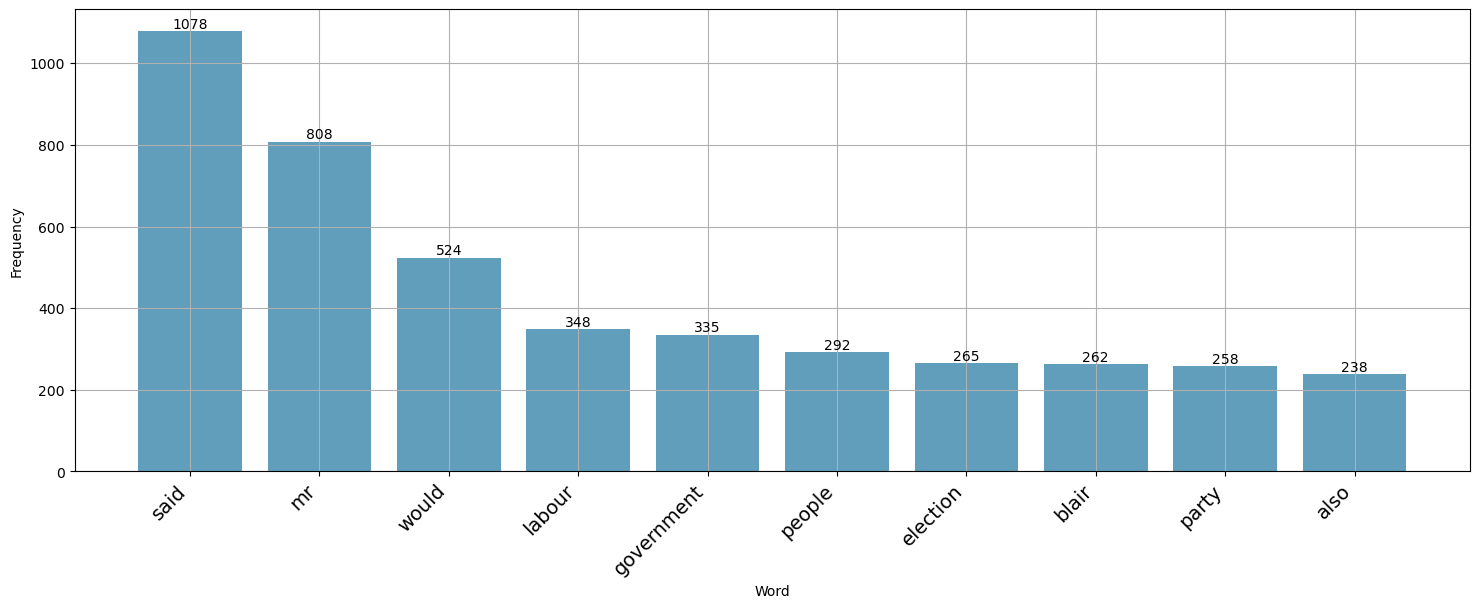

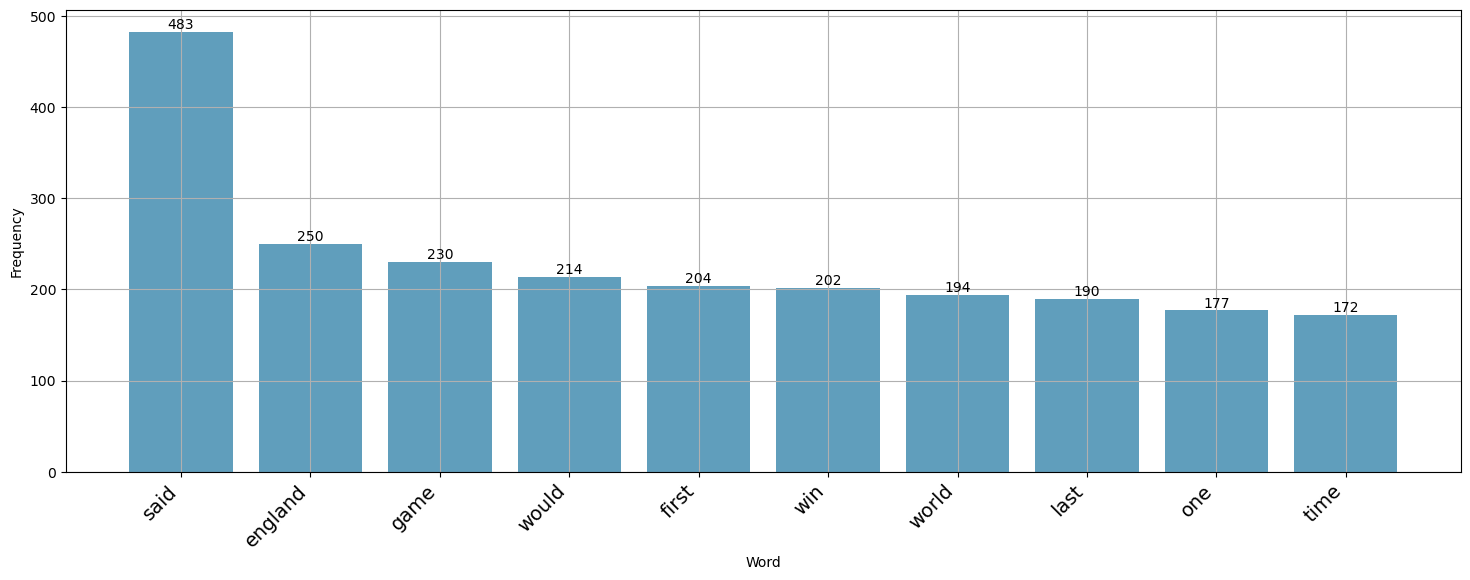

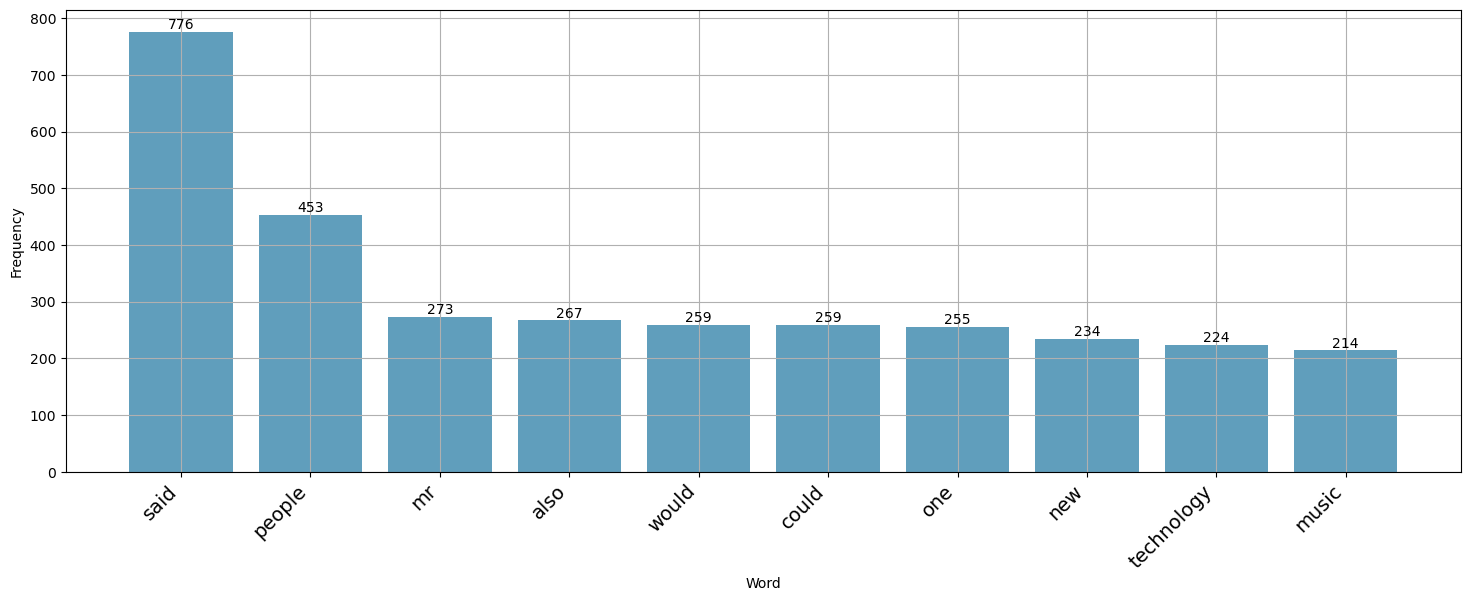

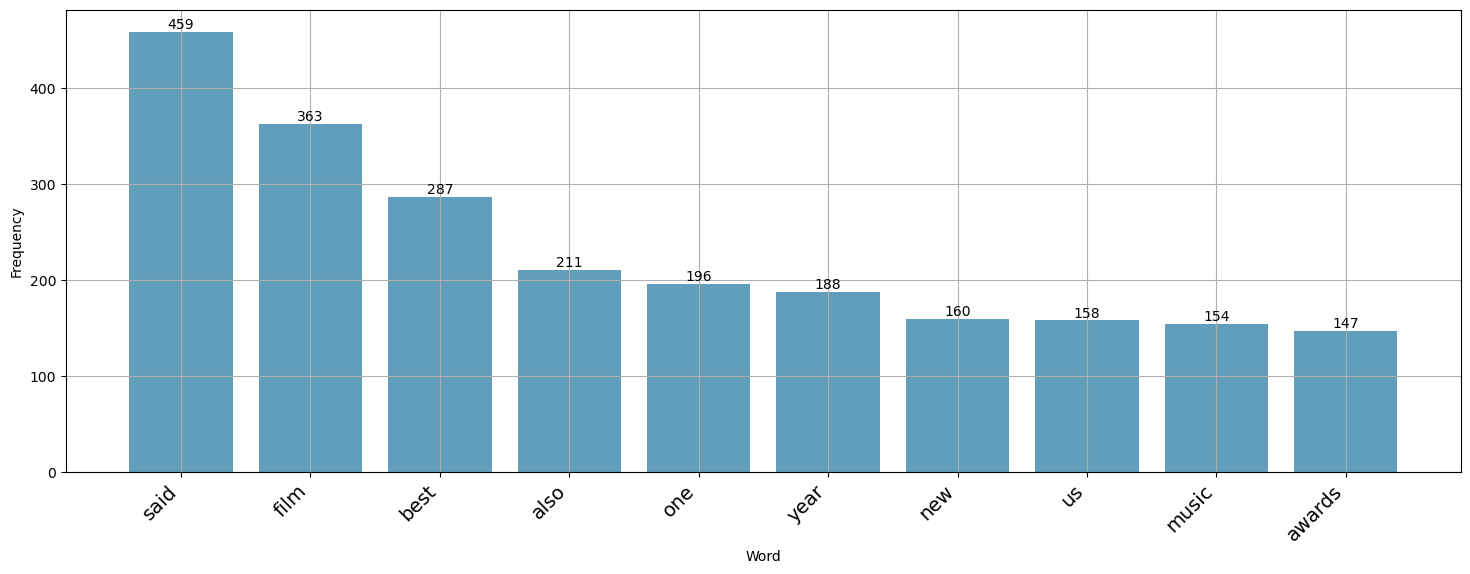

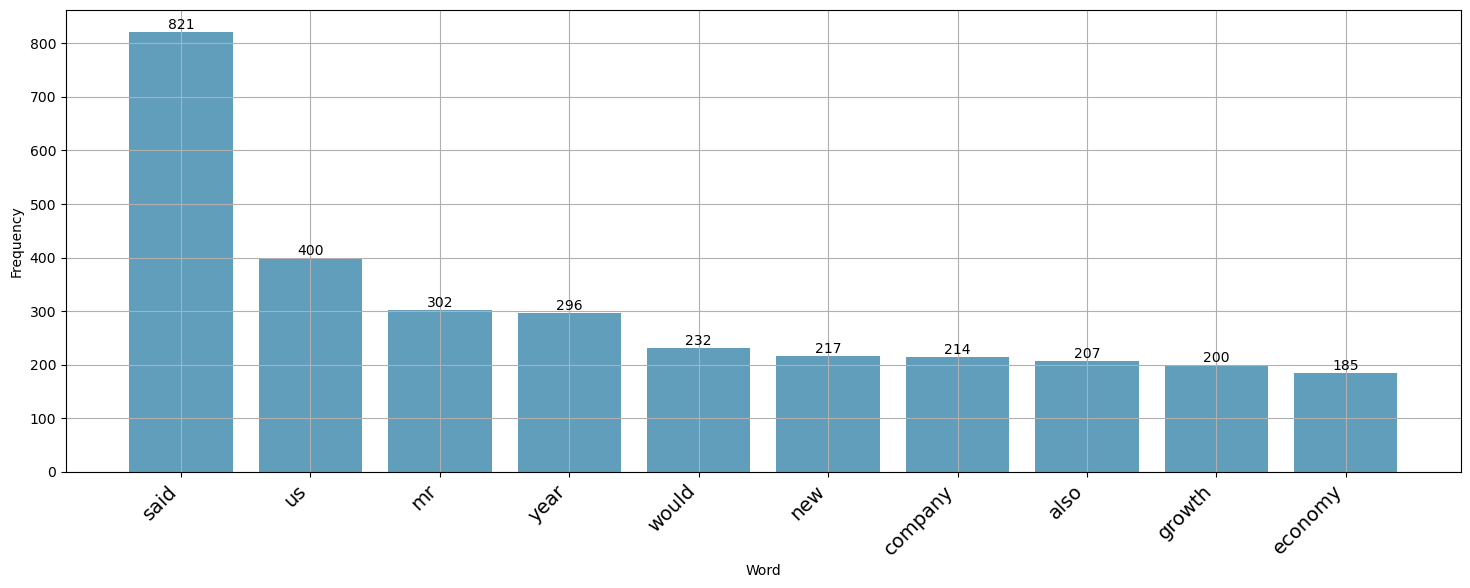

In [22]:
for i in range(5):
    temp = df.loc[df['Label'] == i]
    words = temp['Text'].apply(clean_text).sum()
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(10)
    words, counts = zip(*most_common_words)
    plt.figure(figsize=(18, 6))
    plt.bar(words, counts, color='#609ebc')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, fontsize=14, ha='right')

    for j in range(len(counts)):
        plt.text(j, counts[j], str(counts[j]), ha='center', va='bottom', fontsize=10)
    plt.grid(None)
    plt.show()


<font color="red"> Wyrazy takie jak ‘said’, ‘mr’, ‘would’ pojawiają się we wszystkich tematach tekstów. Bardzo dobrze, że potraktowałyście je tak jak stopwordy i wyrzuciłyście.</font> 

<font color="red">Być może warto usunąć jeszcze jakieś inne, niewiele wnoszące słowa, np. ‘us’.</font>

### 4. Wizualizacja danych

#### 4.1. Wordcloud

Dodatkową wizualizacją może być chmura słów, która pokaże nam, jakie słowa są najczęściej występujące w danych.

In [23]:
colors = ["#62a8c3", "#4d1354", "#9c1a82"]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

Najpierw dla całego zestawu danych (z pominięciem słowa 'said'):

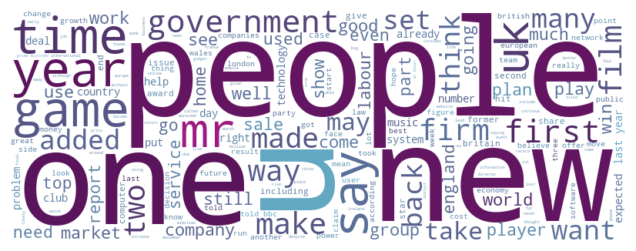

In [24]:
cleaned_text = df['Text'].apply(clean_text).sum()
all_text = ' '.join(cleaned_text)

def remove_word(text, word):
    pattern = r'\b' + re.escape(word) + r'\b'
    cleaned_text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

all_text = remove_word(all_text, 'said')
word_freq = Counter(re.findall(r'\b\w+\b', all_text.lower()))

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    max_frequency = max(word_freq.values())
    min_frequency = min(word_freq.values())
    normalized_freq = (word_freq[word] - min_frequency) / (max_frequency - min_frequency)
    return mcolors.rgb2hex(cmap(normalized_freq))

wordcloud = WordCloud(width=800, height=300, background_color='white', color_func=color_func).generate(all_text)

plt.figure(figsize=(8, 3))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<font color="red">Eleganckie wykresy, dobry pomysł na stworzenie mapy słów. </font>

Następnie dla poszczególnych kategorii:

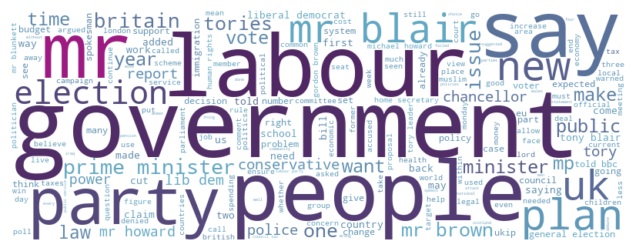

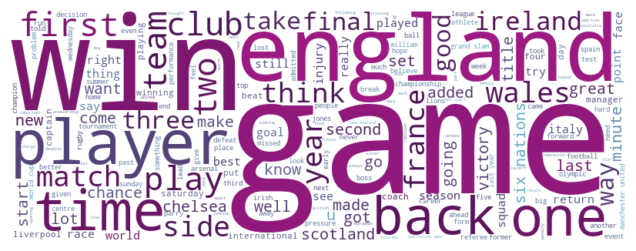

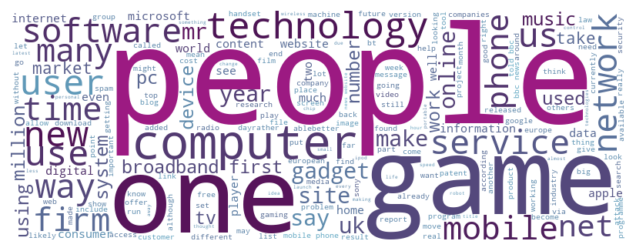

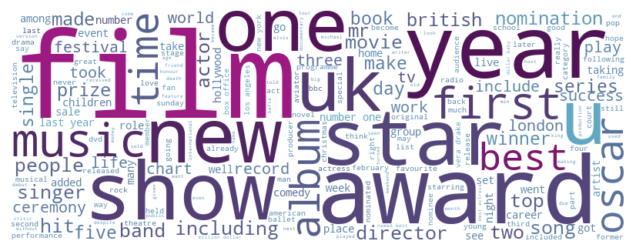

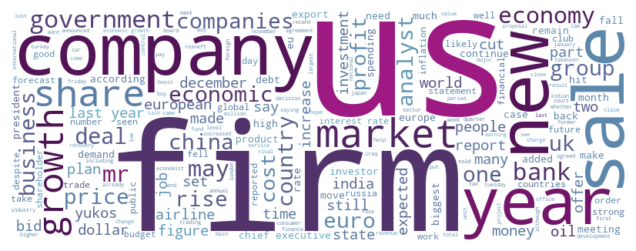

In [25]:
for i in range(5):
    cleaned_text = df.loc[df['Label'] == i, 'Text'].apply(clean_text).sum()
    all_text = ' '.join(cleaned_text)
    all_text = remove_word(all_text, 'said')
    word_freq = Counter(re.findall(r'\b\w+\b', all_text.lower()))

    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        max_frequency = max(word_freq.values())
        min_frequency = min(word_freq.values())
        normalized_freq = (word_freq[word] - min_frequency) / (max_frequency - min_frequency)
        return mcolors.rgb2hex(cmap(normalized_freq))

    wordcloud = WordCloud(width=800, height=300, background_color='white', color_func=color_func).generate(all_text)
    plt.figure(figsize=(8, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

<font color="red">Brak lematyzacji. Usunięto mało istotne słowo ‘said’ dla pewnej grupy tekstów, jednak na wykresie widać, że pozostał rdzeń tego wyrażenia - słowo ‘say’. Lematyzacja rozwiązałaby ten problem. </font>

#### 4.2. plotly

Zobaczmy, jak rozkłada się po 5 najczęstszych słów z każdej kategorii. W celu lepszej wizualizacji słów charakterystycznych dla danych etykiet usunęliśmy ręcznie słowa, które nie mają dużego wkładu semantycznego, a nie zostały wyłapane przez funkcje usuwające stopwords.

In [60]:
results_df = pd.DataFrame()
for i in range(5):
    cleaned_text = df.loc[df['Label'] == i, 'Text'].apply(clean_text).sum()
    all_text = ' '.join(cleaned_text)
    # usuwamy słowa nieistotne semantycznie do klasyfikowania kategorii
    all_text = remove_word(all_text, 'said')
    all_text = remove_word(all_text, 'mr')
    all_text = remove_word(all_text, 'would')
    all_text = remove_word(all_text, 'could')
    all_text = remove_word(all_text, 'also')
    word_freq = Counter(re.findall(r'\b\w+\b', all_text.lower()))
    most_common_words = word_freq.most_common(5)
    word_freq_df = pd.DataFrame(most_common_words, columns=['word', 'count'])
    word_freq_df['label'] = i
    results_df = pd.concat([results_df, word_freq_df], ignore_index=True)
print(results_df)


          word  count  label
0       labour    348      0
1   government    335      0
2       people    292      0
3     election    265      0
4        blair    262      0
5      england    250      1
6         game    230      1
7        first    204      1
8          win    202      1
9        world    194      1
10      people    453      2
11         one    255      2
12         new    234      2
13  technology    224      2
14       music    214      2
15        film    363      3
16        best    287      3
17         one    196      3
18        year    188      3
19         new    160      3
20          us    400      4
21        year    296      4
22         new    217      4
23     company    214      4
24      growth    200      4


In [61]:
fig = px.bar(results_df, x='label', y='count', color='word', text='word')
# # fig = px.bar(word_freq_df, x='word', y='count', title='Częstość występowania słów')
fig.show()

<font color="red"> Oprócz analizy występowania pojedynczych słów, warto przeprowadzić podobną analizę dla ich par, tak zwanych ‘bigramów’. Z drugiej strony można to potraktować już jako część Feature Engineeringu. </font>

#### 4.3. scattertext

Stwórzmy jeszcze wykresy, które pomogą nam przeanalizować jakie słowa są wspólne dla różnych kategorii:

In [57]:
# # ten kod działa, ale wywołuje się bardzo długo
# # otwierają się od razu pliki .html(), które mi się niestety nie załadowały - można próbować, ale nie gwarantuję sukcesu

# # Tworzenie obiektu Scattertext Corpus
# temp = df.copy()


# # Nowe wartości
# temp_labels = {0: 'Politics', 1: 'Sport', 2: 'Technology', 3: 'Entertainment', 4: 'Business'}

# # Podmiana wartości
# temp['Label'] = temp['Label'].replace(temp_labels)



# corpus = st.CorpusFromPandas(temp, category_col='Label', text_col='Text', nlp=st.whitespace_nlp_with_sentences).build()

# # Lista kategorii
# categories = temp['Label'].unique()
# print(categories)

# # Tworzenie wykresu dla każdej kategorii
# for category in categories:
#     html = st.produce_scattertext_explorer(
#         corpus,
#         category=category,  # Kategoria, która będzie wyróżniona
#         category_name=category,
#         not_category_name='Other Categories',
#         width_in_pixels=1000,
#         minimum_term_frequency=1,
#         pmi_threshold_coefficient=0
#     )

#     # Zapisanie wykresu do pliku HTML
#     file_name = f"scattertext_{category}.html"
#     open(file_name, "w").write(html)

#     # Otwieranie pliku w przeglądarce (opcjonalnie)
#     import webbrowser
#     webbrowser.open(file_name)


['Entertainment' 'Business' 'Sport' 'Technology' 'Politics']


<font color="red">Czytelny plik, każde przekształcenia, operacje są klarownie wytłumaczone. Nie trzeba się niczego domyślać.</font>

### 5. Wnioski

- Dane, na których pracujemy, są pozbawione brakujących wartości, jednak zdarzają się duplikaty.
- Fragmenty tekstów reprezentują 5 kategorii, do których docelowo będziemy je klasyfikować: Politics, Technology, Sport, Business, Entertainment.
- W danych typu tekstowego występuje dużo fragmentów zupełnie nieistotnych semantycznie - są to tzw. stopwords, ale też symbole, znaki interpunkcyjne czy liczby.
- Niektóre najczęściej występujące słowa powtarzają się między kategoriami, jednak łatwo da się zauważyć takie, które mogą jednoznacznie wskazywać na konkretną tematykę tekstu.

<font color="red">Plus za wnioski. Widać, że wykonane przekształcenia prowadzą do jakichś konkluzji, nie są to puste komórki kodu, które nie wnoszą nic do postawionego problemu. </font>